In [ ]:
!pip install tensorflow==2.16.1 keras numpy opencv-python matplotlib scikit-learn


In [ ]:
!pip install -U ml_dtypes

  Using cached ml_dtypes-0.5.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
Using cached ml_dtypes-0.5.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (4.9 MB)
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.3 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.1

In [ ]:
# !rm -r data/
# !rm dataset-resized.zip
!unzip -q dataset-resized.zip -d data

In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_dir = 'data/dataset-resized'

### Data Preparation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset='validation'
)


Found 1548 images belonging to 5 classes.
Found 385 images belonging to 5 classes.


### Build Lightweight Model (MobileNetV2)

In [ ]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)


base.trainable = True
for layer in base.layers[:-10]:  # unfreeze only top 10 layers
    layer.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[callback, early_stop]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 51s 887ms/step - accuracy: 0.1862 - loss: 2.2409 - val_accuracy: 0.2156 - val_loss: 2.1280 - learning_rate: 1.0000e-05
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 795ms/step - accuracy: 0.3044 - loss: 1.8260 - val_accuracy: 0.3325 - val_loss: 1.7468 - learning_rate: 1.0000e-05
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 818ms/step - accuracy: 0.4079 - loss: 1.5271 - val_accuracy: 0.3688 - val_loss: 1.6573 - learning_rate: 1.0000e-05
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 885ms/step - accuracy: 0.4338 - loss: 1.4139 - val_accuracy: 0.4052 - val_loss: 1.5770 - learning_rate: 1.0000e-05
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 809ms/step - accuracy: 0.5150 - loss: 1.2841 - val_accuracy: 0.4727 - val_loss: 1.3872 - learning_rate: 1.0000e-05
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 806ms/step - accuracy: 0.5311 - loss: 1.2364 - val_accuracy: 0.4883 - val_loss: 1.3523 - learning_rate: 1.0000e-05
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 809ms/step - acc

In [8]:
history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=15)

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - accuracy: 0.7244 - loss: 0.7553 - val_accuracy: 0.6182 - val_loss: 0.9561
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 821ms/step - accuracy: 0.7230 - loss: 0.7437 - val_accuracy: 0.6156 - val_loss: 0.9840
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 974ms/step - accuracy: 0.6774 - loss: 0.7986 - val_accuracy: 0.6130 - val_loss: 0.9746
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 809ms/step - accuracy: 0.6929 - loss: 0.8106 - val_accuracy: 0.6312 - val_loss: 0.9403
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 830ms/step - accuracy: 0.7344 - loss: 0.7284 - val_accuracy: 0.6260 - val_loss: 0.9370
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 813ms/step - accuracy: 0.7038 - loss: 0.7827 - val_accuracy: 0.6286 - val_loss: 0.9836
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 813ms/step - accuracy: 0.7175 - loss: 0.7362 - val_accuracy: 0.6260 - val_loss: 0.9214
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - accuracy: 0.7153 - loss: 0.7342 - val_accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step
              precision    recall  f1-score   support

       glass       0.22      0.31      0.26       100
       metal       0.17      0.09      0.11        82
       paper       0.23      0.22      0.22       118
     plastic       0.23      0.26      0.24        96
       trash       0.06      0.04      0.04        27

    accuracy                           0.21       423
   macro avg       0.18      0.18      0.18       423
weighted avg       0.20      0.21      0.20       423



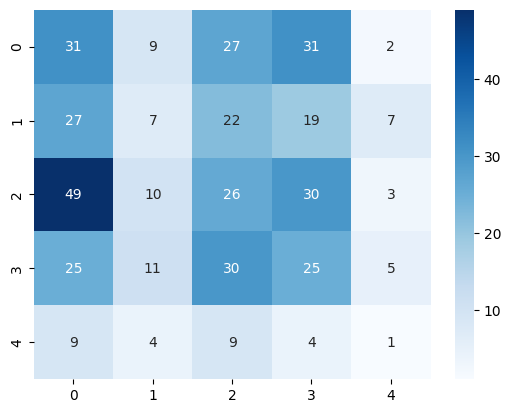

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(val_gen)
y_pred = Y_pred.argmax(axis=1)
cm = confusion_matrix(val_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

print(classification_report(val_gen.classes, y_pred, target_names=val_gen.class_indices.keys()))


### Evaluate and Save Model

In [9]:
acc = model.evaluate(val_gen)[1]
print(f"Validation Accuracy: {acc:.2f}")

model.save('trashnet_mobilenetv2.h5')


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step - accuracy: 0.6298 - loss: 0.8764


Validation Accuracy: 0.66


### Convert to TensorFlow Lite (Quantized)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # full-int8 quantization
tflite_model = converter.convert()

with open('trashnet_model.tflite', 'wb') as f:
    f.write(tflite_model)


AttributeError: 'Sequential' object has no attribute '_get_save_spec'

### Download Model to Your Laptop

In [ ]:
from google.colab import files
files.download('trashnet_model.tflite')
